In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import random
import itertools
from scipy.optimize import minimize, least_squares
from scipy.optimize import NonlinearConstraint
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial import ConvexHull
from scipy.stats import zscore
from itertools import permutations, product

plt.style.use('../notebooks/style.mpl')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.colors as colors
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
import matplotlib as mpl

# Models

## Heterotrophy

Set of metabolites are:
<ul>
    <li> Corg
    <li> NAD
    <li> NADH
    <li> O2
    <li> ATP
    <li> ADP
    <li> CO2
    <li> biomass
</ul>

Set of parameters are:

<ul>
    <li> $\nu_{supply}$
    <li> $\gamma$'s
    <li> $\phi$'s
    <li> total ATP/ADP and NADH/NAD+ pools
</ul>

In [4]:
eps = 1e-10
tau = 1e-4

In [5]:
ZC_org = 2.

In [6]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = 0.0
    x[x>1e8] = 1e8
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP
    
    nu_cat = (NAD ** ZC_org) * phi_cat * gamma_cat_inv * tau
    nu_resp = (NADH ** 2) * phi_resp * gamma_resp_inv * tau
    nu_ana = (NADH ** S6) * (ATP ** S5) * phi_ana * gamma_ana_inv * tau
    
    mu = nu_ana.copy()
    
    # dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    dCorg = 0.0
    # dNADH = ZC_org * nu_cat - 2 * nu_resp - S6 * nu_ana - mu * NADH
    dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = (S3 * nu_cat + S4 * nu_resp - S5 * nu_ana - mu * ATP)
    dADP = -dATP
    
    dydt = np.array([dCorg, dNADH, dO2, dATP])
    return dydt

# Simulations

## Parameters

In [7]:
# gammas are in (g s)/(mol) units.
gamma_cat_inv = 200
gamma_resp_inv = 40
gamma_ana_inv = 200

phi_cat = 0.5
phi_ana = 0.4
phi_resp = 0.1

# Default params: reliance on respiration.
S4 = 4.0    # ATP yield of respiration
S3 = 0.3    # ATP yield of catabolism ... NOTE: default should be 0.5
S5 = 1.1    # ATP cost of anabolism
S6 = 0.2    # reduction coefficient of biomass

### Initial conditions

In [8]:
# micromolar concentrations
Corg0 = 1e1
NADH0 = 1e1
O20 = 1e1
ATP0 = 1e1

# KM is in uM
KM = 100
r1 = 10.
r2 = 0.1

### Dynamics

In [9]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e6
t = np.logspace(-4, 2, 1000 )
S6 = 1.

### Fluxes

In [10]:
def give_nus( y_sol, tpt ):
    x = y_sol[:, tpt].copy()
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]

    NAD = r1 * NADH
    ADP = r2 * ATP

    nu_cat = (NAD ** 2) * phi_cat * gamma_cat_inv * tau
    nu_resp = (NADH ** 2) * phi_resp * gamma_resp_inv * tau
    nu_ana = (NADH ** S6) * (ATP ** S5) * phi_ana * gamma_ana_inv * tau
    
    return np.array([nu_cat, nu_resp, nu_ana])

# Performing simulations

The simulations here are running with chosen parameters for the figure. A detailed parameter scan with the full range of simulations is done elsewhere.

In [11]:
##############################################
## Fig. 1B
##############################################
allmus, allphianas = [], []
# Default params: reliance on respiration.
ZC_org = 2  # NADH yield of carbon source
S4 = 4.0    # ATP yield of respiration
S3 = 0.3    # ATP yield of catabolism
S5 = 1.1    # ATP cost of anabolism
S6 = 0.2    # reduction coefficient of biomass
gamma_cat_inv = 200
gamma_resp_inv = 40
gamma_ana_inv = 200
# everything in units of KM
Corg0 = 1e1
NADH0 = 1e1
O20 = 1e1
ATP0 = 1e1

for indx, t_phi_o in enumerate(np.linspace(0.4, 0.6, 3)):
    mus = []
    phianas = []
    phi_o = t_phi_o
    phi_resp = 0.05

    for t_phi_ana in np.linspace(0.00, 1-phi_o-phi_resp, 200):
        phi_cat = 1-phi_o-phi_resp-t_phi_ana
        phi_ana = t_phi_ana.copy()

        y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e6
        t = np.logspace(-4, 6, 1000 )
        S6 = 1.

        y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y


        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        phianas.append(t_phi_ana)

    mus.append(0.0)
    phianas.append(t_phi_ana)
    allmus.append(mus)
    allphianas.append(phianas)

df_1b = pd.DataFrame({'mus': allmus, 'phianas': allphianas})

##############################################
## Fig. 1C
##############################################
allmus, allnuresps = [], []
tau = 1e-4
# Default params: reliance on respiration.
ZC_org = 2  # NADH yield of carbon source ... NOTE: this is really S2 and no ZC. 
# See comment below for explanation.

S4 = 30.0    # ATP yield of respiration
S3 = 0.2    # ATP yield of catabolism
S5 = 1.4   # ATP cost of anabolism
S6 = 0.2    # reduction coefficient of biomass
# everything in units of KM
Corg0 = 1e1
NADH0 = 1e1
O20 = 1e1
ATP0 = 1e1

gamma_cat_inv = 200
gamma_resp_inv = 400
gamma_ana_inv = 200

phi_o = 0.4
phi_cat = 0.3
legend_elements = []

for indx, t_phi_o in enumerate(np.linspace(0.4, 0.6, 3)):
    phi_o = t_phi_o.copy()
    if indx == 1:
        phi_cat = 0.28
    elif indx == 2:
        phi_cat = 0.25
    mus, phianas, phiresps, allatps, nuresps = [], [], [], [], []
    for t_phi_resp in np.linspace(0.00, 1-phi_o-phi_cat, 200):
        phi_resp = t_phi_resp.copy()
        phi_ana = 1-phi_o-phi_cat-phi_resp

        y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e6
        t = np.logspace(-4, 6, 1000 )
        S6 = 0.5

        y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y


        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        phiresps.append(phi_resp)
        nuresps.append((y_sol[1, -1] ** 2) * phi_resp * gamma_resp_inv * tau)
        allatps.append(y_sol[3, -1])

    allnuresps.append(nuresps)
    allmus.append(mus)

df_1c = pd.DataFrame({'mus': allmus, 'nuresps': allnuresps})

##############################################
## Fig. 1D
##############################################
allmus, allphianas = [], []
# gammas are in (g s)/(mol) units.
gamma_cat_inv = 200
gamma_resp_inv = 40
gamma_ana_inv = 200

# Default params: reliance on respiration.
ZC_org = 2  # NADH yield (ZC) of carbon source
S4 = 4.0    # ATP yield of respiration
S3 = 0.3    # ATP yield of catabolism
S5 = 1.1    # ATP cost of anabolism
S6 = 0.2    # reduction coefficient of biomass

# NADH per C of glucose is 2.0
# Glucose has ZC=0
# CO2 has ZC=+4
# number of electrons released = 4 - 0*6 = 4
# 1 NADH per 2 electrons => 2 NADH per C of glucose

# succinate ZC = +1/2, NC = 4
# if succinate goes to CO2, electrons released = 4 - 1/2*4 = 2 
# so we get 1 NADH per succinate

# In discussion we decided to only vary ZC_org for the main text.
# In the SI we can co-vary ZC_org and S3. 
# We will explicitly avoid coupling S3 (catabolic ATP yield) to 
# ZC_org in this paper. 

tau = 1e-4

cs = ['dodgerblue', 'indianred', 'mediumseagreen']
legend_elements = []
phi_o = 0.4
ZC_org = 2.0

for indx, ZC_org in enumerate(np.linspace(2., 1.6, 3)):
    mus = []
    phianas = []
    phi_resp = 0.05

    for t_phi_ana in np.linspace(0.00, 1-phi_o-phi_resp, 200):
        phi_cat = 1-phi_o-phi_resp-t_phi_ana
        phi_ana = t_phi_ana.copy()

        y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e6
        t = np.logspace(-4, 6, 1000 )
        S6 = 1.

        y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        phianas.append(t_phi_ana)

    mus.append(0.0)
    phianas.append(t_phi_ana)
    allmus.append(mus)
    allphianas.append(phianas)

# resetting carbon source ZC.
ZC_org = 2.0

df_1d = pd.DataFrame({'mus': allmus, 'phianas': allphianas})

##############################################
## Fig. 1E
##############################################
all_mus = []
all_zcs = []

gamma_cat_inv = 200
gamma_resp_inv = 40
gamma_ana_inv = 200


# Default params: reliance on respiration.
NADH0 = 10. # init NADH conc in units of KM
ZC_org = 2  # NADH yield (ZC) of carbon source
S4 = 4.0    # ATP yield of respiration
S3 = 0.3    # ATP yield of catabolism
S5 = 1.1    # ATP cost of anabolism
for indx in range(3):
    mus = []
    zcs = []
    tau = 1e-4
    phi_o = 0.4
    phi_cat = 0.2
    phi_resp = 0.1

    if indx == 1:
        NADH0 = 6.0
    elif indx == 2:
        NADH0 = 14.
        S4 = 20.

    phi_ana = 1 - phi_cat - phi_resp - phi_o

    for S6 in np.linspace(-0.1, 0.5, 100):
        y0 = np.array([Corg0, NADH0, O20, ATP0])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e6
        t = np.logspace(-4, 6, 1000)

        y_sol = solve_ivp(het_model, [1e-4, TFINAL], y0, t_eval=t, method='Radau').y

        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        zcs.append(S6)

    all_mus.append(mus)
    all_zcs.append(zcs)

df_1e = pd.DataFrame({'mus': all_mus, 'zcs': all_zcs})


# Plotting Fig. 1

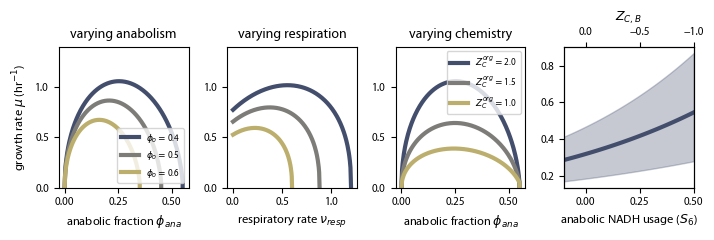

In [12]:
# Create the figure
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(7.24, 2.5))

##############################################
## Fig. 1B
##############################################
plt.sca(axs[0])
plt.ylabel('growth rate ' + r'$\mu$' + ' (hr$^{-1}$)')
plt.xlabel('anabolic fraction ' + r'$\phi_{ana}$')

cs = sns.color_palette('cividis', 3)
#cs = ['dodgerblue', 'indianred', 'mediumseagreen']
legend_elements = []

phi_os=np.linspace(0.4, 0.6, 3)
for indx in range(len(df_1b)):
    phianas = df_1b.iloc[indx]['phianas']
    mus = df_1b.iloc[indx]['mus']
    plt.plot( phianas, mus, lw=3, c=cs[indx] )
    legend_elements.append(r'$\phi_o = $' + str(phi_os[indx]))
plt.legend(legend_elements, loc=4, fontsize=6.5)

##############################################
## Fig. 1C
##############################################
plt.sca(axs[1])
plt.ylabel( '')
plt.xlabel( 'respiratory rate ' + r'$\nu_{resp}$' )

#cs = ['dodgerblue', 'indianred', 'mediumseagreen']

for indx in range(len(df_1c)):
    nuresps = df_1c.iloc[indx]['nuresps']
    mus = df_1c.iloc[indx]['mus']
    plt.plot( nuresps, mus, lw=3, c=cs[indx] )
    legend_elements.append(r'$\phi_o = $' + str(phi_os[indx]))

plt.legend(legend_elements, loc='best').set_visible(False)

##############################################
## Fig. 1D
##############################################
plt.sca(axs[2])
plt.ylabel( '')
plt.xlabel( 'anabolic fraction ' + r'$\phi_{ana}$' )

legend_elements = []
#cs = ['dodgerblue', 'indianred', 'mediumseagreen']

for indx, ZC_org in enumerate(np.linspace(2.0, 1.0, 3)):
    phianas = df_1d.iloc[indx]['phianas']
    mus = df_1d.iloc[indx]['mus']
    plt.plot( phianas, mus, lw=3, c=cs[indx] )
    legend_elements.append(r'$Z_C^{org} = $' + str(ZC_org))

# resetting carbon source ZC.
ZC_org = 2.0
plt.legend(legend_elements, loc='best', fontsize=6.5)

##############################################
## Fig. 1E
##############################################
plt.sca(axs[3])
plt.ylabel('')
plt.xlabel('anabolic NADH usage (' + r'$S_6$' + ')')

#cs = ['dodgerblue', 'indianred', 'mediumseagreen']
all_mus = df_1e['mus']
all_zcs = df_1e['zcs']

for indx in range(3):
    S6s = all_zcs[indx]
    mus = all_mus[indx]
    if indx == 1 or indx == 2:
        plt.plot(S6s, mus, lw=0, c=cs[indx])
    else:
        plt.plot(S6s, mus, lw=3, c=cs[indx])

# Filling the gap between the second and third curves
if len(all_mus) >= 3:
    plt.fill_between(all_zcs[1], all_mus[1], all_mus[2], alpha=0.3, color=cs[0])
# need to define the x-axis limits that map directly to the ZC values.
plt.xlim(np.min(S6s), np.max(S6s))
plt.xticks(np.arange(0, 0.51, 0.25))

# Add parallel x-axis
# ticks, labels = axs[3].get_xticks()
ax2 = plt.twiny()
# In this plot we assume the C-source is glucose which has ZC=0.
# Hence ZC = -2*S6, where S6 is anabolic stoichiomtery of NADH when using
# glucose as the effective substrat. 
zcs = -np.array(S6s) * 2
ax2.plot(zcs, mus, lw=0, c=cs[indx])
# Need to invert the x-axis so that the direction matches the main x-axis.
ax2.set_xlim(zcs.max(), zcs.min())
plt.xlabel(r'$Z_{C,B}$')

# Ticks for panels B-D
gr_yticks = np.arange(0, 1.1, 0.5)
titles = 'varying anabolism,varying respiration,varying chemistry'.split(',')
for ax, t in zip(axs[:-1], titles):
    plt.sca(ax)
    plt.yticks(gr_yticks)
    plt.ylim(0.0, 1.4)
    plt.title(t)

plt.tight_layout()
plt.savefig('../output/Fig1.png', facecolor='w', dpi=300)
plt.show()

In [13]:
# Calculate a confidence interval for the slope of the mu/ZC curve.
slope_u_s6 = (all_mus[0][-1] - all_mus[0][0])/(all_zcs[0][-1] - all_zcs[0][0])
slope_u_ZC = slope_u_s6 / 2
print('mu/ZC slope = {0:.2f}'.format(slope_u_ZC))

mu/ZC slope = 0.22
